In [1]:
from importlib import reload
#reload(Utilities)
#reload(clm)
# NOTE: To reload a class imported as, e.g., 
# from module import class
# One must call:
#   1. import module
#   2. reload module
#   3. from module import class

import sys, os
import re

import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype, is_datetime64_dtype, is_timedelta64_dtype
from scipy import stats
import datetime
import time
from natsort import natsorted, ns, natsort_keygen
from packaging import version

import itertools

import pyodbc
#---------------------------------------------------------------------
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
from matplotlib import dates
#---------------------------------------------------------------------
sys.path.insert(0, os.path.realpath('..'))
import Utilities_config
#-----
import CommonLearningMethods as clm
#-----
from MeterPremise import MeterPremise
#-----
from AMI_SQL import AMI_SQL, DfToSqlMap
from AMINonVee_SQL import AMINonVee_SQL
from AMIEndEvents_SQL import AMIEndEvents_SQL
from AMIUsgInst_SQL import AMIUsgInst_SQL
from DOVSOutages_SQL import DOVSOutages_SQL
#-----
from GenAn import GenAn
from AMINonVee import AMINonVee
from AMIEndEvents import AMIEndEvents
from AMIUsgInst import AMIUsgInst
from DOVSOutages import DOVSOutages
#---------------------------------------------------------------------
sys.path.insert(0, Utilities_config.get_sql_aids_dir())
import Utilities_sql
import TableInfos
from TableInfos import TableInfo
from SQLElement import SQLElement
from SQLElementsCollection import SQLElementsCollection
from SQLSelect import SQLSelectElement, SQLSelect
from SQLFrom import SQLFrom
from SQLWhere import SQLWhereElement, SQLWhere
from SQLJoin import SQLJoin, SQLJoinCollection
from SQLGroupBy import SQLGroupByElement, SQLGroupBy
from SQLHaving import SQLHaving
from SQLOrderBy import SQLOrderByElement, SQLOrderBy
from SQLQuery import SQLQuery
from SQLQueryGeneric import SQLQueryGeneric
#---------------------------------------------------------------------
#sys.path.insert(0, os.path.join(os.path.realpath('..'), 'Utilities'))
sys.path.insert(0, Utilities_config.get_utilities_dir())
import Utilities
import Utilities_df
from Utilities_df import DFConstructType
import Utilities_dt
import Plot_Box_sns
import GrubbsTest

In [2]:
def build_outages_and_ami(
    outg_sql_function_kwargs,
    search_time_half_window, 
    df_construct_type=DFConstructType.kRunSqlQuery, 
    merge_outg_w_mp=True, 
    match_events_in_df_to_outages=False, 
    verbose=True, 
    **kwargs
):
    #--------------------------------------------------
    # Unpack kwargs
    #TODO should these addtnl arguments go in kwargs, or should they explicitly be in function arguments?
    addtnl_usg_sql_function_kwargs        = kwargs.get('addtnl_usg_sql_function_kwargs', {})
    addtnl_usg_inst_sql_function_kwargs   = kwargs.get('addtnl_usg_inst_sql_function_kwargs', {})
    addtnl_end_events_sql_function_kwargs = kwargs.get('addtnl_end_events_sql_function_kwargs', {})
    #-----
    cols_of_interest_usage         = kwargs.get('cols_of_interest_usage', TableInfos.AMINonVee_TI.std_columns_of_interest)
    cols_of_interest_usg_inst      = kwargs.get('cols_of_interest_usg_inst', TableInfos.AMIUsgInst_TI.std_columns_of_interest)
    cols_of_interest_end_dev_event = kwargs.get('cols_of_interest_end_dev_event', TableInfos.AMIEndEvents_TI.std_columns_of_interest)
    cols_of_interest_met_prem      = kwargs.get('cols_of_interest_met_prem', TableInfos.MeterPremise_TI.std_columns_of_interest)
    #-----
    contstruct_df_args_outage     = kwargs.get('contstruct_df_args_outage', None)
    contstruct_df_args_usg        = kwargs.get('contstruct_df_args_usg', None)
    contstruct_df_args_usg_inst   = kwargs.get('contstruct_df_args_usg_inst', None)
    contstruct_df_args_end_events = kwargs.get('contstruct_df_args_end_events', None)  
    #--------------------------------------------------
    start=time.time()
    dovs_outgs = DOVSOutages(
        df_construct_type=df_construct_type, 
        contstruct_df_args = contstruct_df_args_outage, 
        build_sql_function_kwargs=outg_sql_function_kwargs, 
        init_df_in_constructor=True
    )
    outg_build_time = time.time()-start
    #--------------------------------------------------
    dovs_outgs.set_search_time(search_time_half_window=search_time_half_window)
    #--------------------------------------------------
    if merge_outg_w_mp:
        outg_shape_before = dovs_outgs.get_df().shape
        start=time.time()
        dovs_outgs.merge_df_with_mp(cols_of_interest_met_prem=cols_of_interest_met_prem)
        outg_shape_after = dovs_outgs.get_df().shape
        merge_outg_w_mp_time = time.time()-start
    #--------------------------------------------------
    usg_sql_function_kwargs = dict(
        cols_of_interest=cols_of_interest_usage, 
        df_outage=dovs_outgs.get_df(), 
        join_mp_args=dict(join_with_CTE=True, 
                          build_mp_kwargs=dict(cols_of_interest=cols_of_interest_met_prem))
    )
    usg_sql_function_kwargs = {**usg_sql_function_kwargs, 
                               **addtnl_usg_sql_function_kwargs}
    start=time.time()
    usg = AMINonVee(
        df_construct_type=df_construct_type, 
        contstruct_df_args = contstruct_df_args_usg, 
        build_sql_function=AMINonVee_SQL.build_sql_usg_for_outages, 
        build_sql_function_kwargs=usg_sql_function_kwargs, 
        init_df_in_constructor=True
    )
    usg_build_time = time.time()-start
    #--------------------------------------------------
    end_events_sql_function_kwargs = dict(
        cols_of_interest=cols_of_interest_end_dev_event, 
        df_outage=dovs_outgs.get_df(), 
        join_mp_args=dict(join_with_CTE=True, 
                          build_mp_kwargs=dict(cols_of_interest=cols_of_interest_met_prem))
    )
    end_events_sql_function_kwargs = {**end_events_sql_function_kwargs, 
                                      **addtnl_end_events_sql_function_kwargs}
    start=time.time()
    end_events = AMIEndEvents(
        df_construct_type=df_construct_type, 
        contstruct_df_args = contstruct_df_args_end_events, 
        build_sql_function=AMIEndEvents_SQL.build_sql_end_events_for_outages, 
        build_sql_function_kwargs=end_events_sql_function_kwargs, 
        init_df_in_constructor=True
    )
    end_events_build_time = time.time()-start
    #--------------------------------------------------
    usg_inst_sql_function_kwargs = dict(
        cols_of_interest=cols_of_interest_usg_inst, 
        df_outage=dovs_outgs.get_df(), 
        join_mp_args=dict(join_with_CTE=True, 
                          build_mp_kwargs=dict(cols_of_interest=cols_of_interest_met_prem))
    )
    usg_inst_sql_function_kwargs = {**usg_inst_sql_function_kwargs, 
                                    **addtnl_usg_inst_sql_function_kwargs}
    start=time.time()
    usg_inst = AMIUsgInst(
        df_construct_type=df_construct_type, 
        contstruct_df_args = contstruct_df_args_usg_inst, 
        build_sql_function=AMIUsgInst_SQL.build_sql_usg_inst_for_outages, 
        build_sql_function_kwargs=usg_inst_sql_function_kwargs, 
        init_df_in_constructor=True
    ) 
    usg_inst_build_time = time.time()-start
    #--------------------------------------------------
    if verbose:
        print(f'Time to build dovs_outgs: {outg_build_time}')
        if merge_outg_w_mp:
            print(f'df shape before join with MP: {outg_shape_before}')
            print(f'Time to join with MP: {merge_outg_w_mp_time}')
            print(f'df shape after join with MP: {outg_shape_after}')   
        print(f'Time to build usg: {usg_build_time}')
        print(f'Time to build end events: {end_events_build_time}')
        print(f'Time to build usg inst: {usg_inst_build_time}')
    #--------------------------------------------------
    return {
        'dovs_outgs':dovs_outgs, 
        'usg':usg, 
        'end_events':end_events, 
        'usg_inst':usg_inst
    }

In [3]:
conn_outages = Utilities.get_utldb01p_oracle_connection()
conn_aws = Utilities.get_athena_prod_aws_connection()
conn_eemsp = Utilities.get_eemsp_oracle_connection()

In [4]:
save_dfs_to_csv = False
read_dfs_from_csv = True
save_dir = os.path.join(Utilities_config.get_local_data_dir(), r'dovs_and_ami_data')

assert(save_dfs_to_csv+read_dfs_from_csv <=1) # Should never both read and write!

df_construct_type=DFConstructType.kRunSqlQuery
if read_dfs_from_csv:
    df_construct_type=DFConstructType.kReadCsv

In [5]:
# NOTE
# 11946344 is scheduled output.  So, there are apparently no corresponding end events!

# #dates_of_outages = ['2020-10-12']
# outg_rec_nbs = ['11947217', '11946640', '11946344']

# #dates_of_outages = ['2020-10-12', '2017-09-16']
# outg_rec_nbs = ['11947217', '11946640', '11946344', '10143524']

# #dates_of_outages = ['2020-10-12', '2017-09-16']
# outg_rec_nbs = ['11947217', '11946640', '10143524']

# #dates_of_outages = ['2020-07-01']
# outg_rec_nbs = ['11770899']

# #dates_of_outages = ['2020-10-12', '2017-09-16', '2020-07-01']
outg_rec_nbs = ['11947217', '11946640', '10143524', '11770899']

# outg_rec_nbs = ['11947217', '11946640', '10143524', '11770899', '11751094', '11738944', 
#                 '11496239', '11818003', '11833199', '11851647', '12022118']

In [6]:
search_time_half_window = datetime.timedelta(days=3)
#-------------------------
cols_of_interest_usage         = TableInfos.AMINonVee_TI.std_columns_of_interest
cols_of_interest_usg_inst      = TableInfos.AMIUsgInst_TI.std_columns_of_interest
cols_of_interest_end_dev_event = TableInfos.AMIEndEvents_TI.std_columns_of_interest
#-----
cols_of_interest_met_prem      = TableInfos.MeterPremise_TI.std_columns_of_interest
#-------------------------
match_events_in_df_to_outages=False
combine_kwh_delivered_and_received=True
#-------------------------

In [7]:
#-------------------------
addtnl_usg_sql_function_kwargs = dict(
    build_usg_kwargs=dict(
        opco='oh', 
        aep_derived_uoms_and_idntfrs=None
    )
)
#-------------------------
addtnl_usg_inst_sql_function_kwargs = dict(
    build_usg_kwargs=dict(opco='oh')
)
#-------------------------
addtnl_end_events_sql_function_kwargs = dict(
    build_usg_kwargs=dict(opco='oh')
)
#-------------------------
outages_and_ami = build_outages_and_ami(
    outg_sql_function_kwargs=dict(outg_rec_nbs=outg_rec_nbs), 
    search_time_half_window=search_time_half_window, 
    df_construct_type=df_construct_type, 
    merge_outg_w_mp=True, 
    addtnl_usg_sql_function_kwargs=addtnl_usg_sql_function_kwargs, 
    addtnl_usg_inst_sql_function_kwargs=addtnl_usg_inst_sql_function_kwargs, 
    addtnl_end_events_sql_function_kwargs=addtnl_end_events_sql_function_kwargs, 
    cols_of_interest_usage = cols_of_interest_usage, 
    cols_of_interest_usg_inst = cols_of_interest_usg_inst, 
    cols_of_interest_end_dev_event = cols_of_interest_end_dev_event, 
    cols_of_interest_met_prem = cols_of_interest_met_prem, 
    match_events_in_df_to_outages=False, 
    contstruct_df_args_outage=dict(file_path=os.path.join(save_dir, 'dovs_outgs.csv')), 
    contstruct_df_args_usg=dict(file_path=os.path.join(save_dir, 'usg.csv')), 
    contstruct_df_args_usg_inst=dict(file_path=os.path.join(save_dir, 'usg_inst.csv')), 
    contstruct_df_args_end_events=dict(file_path=os.path.join(save_dir, 'end_events.csv')), 
    verbose=True
)

Time to build dovs_outgs: 0.01642632484436035
df shape before join with MP: (64, 29)
Time to join with MP: 86.13214182853699
df shape after join with MP: (64, 30)
Time to build usg: 0.364424467086792
Time to build end events: 0.01833963394165039
Time to build usg inst: 0.02219986915588379


In [8]:
# If reading from CSV, if dovs_outgs in CSV was created with merge_outg_w_mp=True and 
# merge_outg_w_mp=True when called, columns will be repeated (e.g., two serial_number columns)
# The following line eliminates that duplication
if read_dfs_from_csv:
    outages_and_ami['dovs_outgs'].df = outages_and_ami['dovs_outgs'].df.loc[:, ~outages_and_ami['dovs_outgs'].df.columns.duplicated()]

In [9]:
dovs_outgs = outages_and_ami['dovs_outgs']
usg        = outages_and_ami['usg']
end_events = outages_and_ami['end_events']
usg_inst   = outages_and_ami['usg_inst']
#-------------------------
df_outage_OG = dovs_outgs.get_df().copy()
df_usg_OG = usg.get_df().copy()
df_end_events_OG = end_events.get_df().copy()
df_usg_inst_OG = usg_inst.get_df().copy()
#-------------------------
if save_dfs_to_csv:
    dovs_outgs.write_df_to_csv(os.path.join(save_dir, 'dovs_outgs.csv'))
    usg.write_df_to_csv(os.path.join(save_dir, 'usg.csv'))
    end_events.write_df_to_csv(os.path.join(save_dir, 'end_events.csv'))
    usg_inst.write_df_to_csv(os.path.join(save_dir, 'usg_inst.csv'))

# ----------------------------------

In [10]:
df_outage     = df_outage_OG.copy()
df_usg        = df_usg_OG.copy()
df_usg_inst   = df_usg_inst_OG.copy()
df_end_events = df_end_events_OG.copy()

In [11]:
df_outage['OUTG_REC_NB'].value_counts()

10143524    24
11947217    23
11770899    13
11946640     4
Name: OUTG_REC_NB, dtype: int64

In [12]:
df_usg = clm.remove_table_aliases(df_usg)
df_usg = AMINonVee.perform_std_initiation_and_cleaning(df_usg)
if combine_kwh_delivered_and_received:
    df_usg = AMINonVee.combine_kwh_delivered_and_received_values(df_usg)
if match_events_in_df_to_outages:
    start = time.time()
    df_usg, n_events_with_mult_matches = clm.match_events_in_df_to_outages(
        df_usg, df_outage, 
        return_n_events_with_mult_matches=True, 
        events_cols = {'premise_nb':'aep_premise_nb', 
                       'event_time':'starttimeperiod_utc'}
    )
    cols_to_return_from_df_outage = ['DT_OFF_TS_FULL', 'DT_ON_TS', 'STEP_DRTN_NB', 'search_time_half_window', 'LOCATION_ID', 'GIS_CRCT_NB']
    placement_cols =                ['DT_OFF_TS_FULL', 'DT_ON_TS', 'STEP_DRTN_NB', 'search_time_half_window', 'LOCATION_ID', 'GIS_CRCT_NB']
    df_usg = clm.set_all_outages_info_in_events_df(
        df_usg, df_outage, 
        cols_to_return_from_df_outage=cols_to_return_from_df_outage, 
        placement_cols=placement_cols
    )
    time_new = time.time() - start
    print(f'n_events_with_mult_matches = {n_events_with_mult_matches}')
    #-------------------------
    # Need to be a little careful with n_events_with_mult_matches below, as values were exploded in match_events_in_df_to_outages
    # Therefore, naively taking df_usg[df_usg['n_outages_found'] > 1].shape[0] would overcount.
    #   e.g., if every event with 'n_outages_found'>1 found two outages, the value returned by the naive method mentioned
    #         above would be twice the actual value
    # Not sure what solution is for this case!
    #n_events_with_mult_matches = df_usg[df_usg['n_outages_found'] > 1].shape[0]
    n_events_with_no_matches = df_usg[df_usg['n_outages_found'] < 1].shape[0]
    #print(f'n_events_with_mult_matches = {n_events_with_mult_matches}')
    print(f'n_events_with_no_matches = {n_events_with_no_matches}')

In [13]:
df_usg_inst = AMIUsgInst.perform_std_initiation_and_cleaning(df_usg_inst)
df_end_events = AMIEndEvents.perform_std_initiation_and_cleaning(df_end_events)

In [14]:
sort_by_usg = ['aep_endtime_utc', 'serialnumber', 'aep_derived_uom', 'aep_srvc_qlty_idntfr']
#sort_by_usg = ['serialnumber', 'aep_endtime_utc', 'aep_derived_uom', 'aep_srvc_qlty_idntfr']
df_usg.sort_values(by=sort_by_usg)

,serialnumber,aep_premise_nb,starttimeperiod,endtimeperiod,aep_endtime_utc,timezoneoffset,aep_derived_uom,aep_srvc_qlty_idntfr,value,aep_opco,...,srvc_pole_nb,trsf_pole_nb,latitude_nb,longitude_nb,station_nb,xfmr_nb,outg_rec_nb,aep_endtime_utc_from_timestamp,starttimeperiod_utc,endtimeperiod_utc
time_idx,,,,,,,,,,,,,,,,,,,,,
2020-06-28 18:45:00,682540032,077308983,2020-06-28T14:30:00-04:00,2020-06-28T14:45:00-04:00,1593369900,-1 days +20:00:00,AMP,INSTCURA1,14.600000,oh,...,41830774A20282,41830774B10216,40.8232183,-83.2817183,2017,4,11770899,2020-06-28 18:45:00,2020-06-28 18:30:00,2020-06-28 18:45:00
2020-06-28 18:45:00,682540032,077308983,2020-06-28T14:30:00-04:00,2020-06-28T14:45:00-04:00,1593369900,-1 days +20:00:00,KVAH,DELIVERED,0.769500,oh,...,41830774A20282,41830774B10216,40.8232183,-83.2817183,2017,4,11770899,2020-06-28 18:45:00,2020-06-28 18:30:00,2020-06-28 18:45:00
2020-06-28 18:45:00,682540032,077308983,2020-06-28T14:30:00-04:00,2020-06-28T14:45:00-04:00,1593369900,-1 days +20:00:00,KVARH,NET,0.237000,oh,...,41830774A20282,41830774B10216,40.8232183,-83.2817183,2017,4,11770899,2020-06-28 18:45:00,2020-06-28 18:30:00,2020-06-28 18:45:00
2020-06-28 18:45:00,682540032,077308983,2020-06-28T14:30:00-04:00,2020-06-28T14:45:00-04:00,1593369900,-1 days +20:00:00,KWH,TOTAL,0.726000,oh,...,41830774A20282,41830774B10216,40.8232183,-83.2817183,2017,4,11770899,2020-06-28 18:45:00,2020-06-28 18:30:00,2020-06-28 18:45:00
2020-06-28 18:45:00,682540032,077308983,2020-06-28T14:30:00-04:00,2020-06-28T14:45:00-04:00,1593369900,-1 days +20:00:00,VOLT,INSTVA1,119.199997,oh,...,41830774A20282,41830774B10216,40.8232183,-83.2817183,2017,4,11770899,2020-06-28 18:45:00,2020-06-28 18:30:00,2020-06-28 18:45:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-16 01:00:00,881984523,101330620,2020-10-15T20:45:00-04:00,2020-10-15T21:00:00-04:00,1602810000,-1 days +20:00:00,KWH,TOTAL,0.174000,oh,...,1873015753590,1873015753590,40.06823800,-82.9532280,0009,NaN,11947217,2020-10-16 01:00:00,2020-10-16 00:45:00,2020-10-16 01:00:00
2020-10-16 01:00:00,881984523,101330620,2020-10-15T20:45:00-04:00,2020-10-15T21:00:00-04:00,1602810000,-1 days +20:00:00,VOLT,AVG,239.300003,oh,...,1873015753590,1873015753590,40.06823800,-82.9532280,0009,NaN,11947217,2020-10-16 01:00:00,2020-10-16 00:45:00,2020-10-16 01:00:00
2020-10-16 01:00:00,882468091,108130620,2020-10-15T20:45:00-04:00,2020-10-15T21:00:00-04:00,1602810000,-1 days +20:00:00,KVAH,DELIVERED,0.295000,oh,...,1873015753590,1873015753590,40.06827500,-82.9535730,0009,NaN,11947217,2020-10-16 01:00:00,2020-10-16 00:45:00,2020-10-16 01:00:00


In [15]:
set(df_usg['serialnumber'].unique()).symmetric_difference(set(df_usg_inst['serialnumber'].unique()))

{'881902429',
 '883024353',
 '883024354',
 '883024355',
 '883024356',
 '883024464',
 '883407953',
 '883409939',
 '883409944',
 '883409945',
 '883409946',
 '883409947'}

In [16]:
set(df_usg['serialnumber'].unique()).symmetric_difference(set(df_end_events['serialnumber'].unique()))

{'883024353', '883024354', '883024355', '883407953', '883409939'}

In [17]:
set(df_usg_inst['serialnumber'].unique()).symmetric_difference(set(df_end_events['serialnumber'].unique()))

{'881902429',
 '883024356',
 '883024464',
 '883409944',
 '883409945',
 '883409946',
 '883409947'}

In [18]:
# df_usg['serialnumber'].unique().tolist()+df_usg_inst['serialnumber'].unique().tolist()

In [19]:
all_sns = set(df_usg['serialnumber'].unique().tolist() + 
              df_usg_inst['serialnumber'].unique().tolist() + 
              df_end_events['serialnumber'].unique().tolist())

all_shared_sns = set.intersection(
    set(df_usg['serialnumber'].unique()), 
    set(df_usg_inst['serialnumber'].unique().tolist()), 
    set(df_end_events['serialnumber'].unique().tolist())
)

In [20]:
print(len(all_sns))
print(df_usg['serialnumber'].nunique())
print(df_usg_inst['serialnumber'].nunique())
print(df_end_events['serialnumber'].nunique())
print(len(all_shared_sns))

40
40
28
35
28


In [21]:
# df_usg.head()

In [22]:
# df_usg_inst.head()

In [23]:
# df_end_events.head()

In [24]:
df_outage['PREMISE_NB'].unique()

array(['101137530', '107337530', '107726383', '109236383', '070508983',
       '071048983', '071108983', '072018983', '073608983', '074148983',
       '074208983', '075738983', '075897983', '076708983', '077308983',
       '078838983', '079808983', '100420620', '100547600', '100683783',
       '101020620', '101330620', '102920620', '103520620', '103647600',
       '103783783', '104120620', '104430620', '105030620', '105293783',
       '105710620', '106620620', '106747600', '106883783', '107220620',
       '107483783', '108130620', '108393783', '108810620', '109720620',
       '109847600'], dtype=object)

In [25]:
[x for x in df_outage['PREMISE_NB'].unique() if x not in df_usg['aep_premise_nb'].unique()]

['102920620']

In [26]:
print(df_outage['OUTG_REC_NB'].unique().tolist())
print(df_usg['outg_rec_nb'].unique().tolist())
print(df_usg_inst['outg_rec_nb'].unique().tolist())
print(df_end_events['outg_rec_nb'].unique().tolist())

[11946640, 11770899, 10143524, 11947217]
[11770899, 11946640, 11947217]
[11770899, 11946640, 11947217]
[10143524, 11770899, 11946640, 11947217]


In [27]:
class Outage:
    def __init__(self, 
                 outg_rec_nb, 
                 dovs_outgs, 
                 usg, 
                 usg_inst=None, 
                 end_events=None, 
                 outage_info_dict=None):
        self.outg_rec_nb = outg_rec_nb
        self.df_outage = Outage.get_df_subset_for_outage(df=dovs_outgs, outg_rec_nb=self.outg_rec_nb)
        self.df_usg    = Outage.get_df_subset_for_outage(df=usg, outg_rec_nb=self.outg_rec_nb)
        #-----
        if usg_inst is not None:
            self.df_usg_inst = Outage.get_df_subset_for_outage(df=usg_inst, outg_rec_nb=self.outg_rec_nb)
        else:
            self.df_usg_inst = None
        #-----
        if end_events is not None:
            self.df_end_events = Outage.get_df_subset_for_outage(df=end_events, outg_rec_nb=self.outg_rec_nb)
        else:
            self.df_end_events = None        
        #-----
        if outage_info_dict is None:
            self.outage_info_dict = Outage.build_outage_info_dict(df=self.df_outage, 
                                                                  outg_rec_nb=self.outg_rec_nb)
        else:
            self.outage_info_dict = outage_info_dict
        
        
        
    @staticmethod
    def get_df_subset_for_outage(df, outg_rec_nb, return_copy=True, outg_rec_nb_col=None):
        r"""
        If outg_rec_nb_col is None, try 'outg_rec_nb' and 'OUTG_REC_NB'
        If the outage record number is stored in a different column, the user must supply it.
        NOTE: If outg_rec_nb_col is None, the df should only have 'outg_rec_nb' or 'OUTG_REC_NB', NOT BOTH
        """
        #-------------------------
        if isinstance(df, GenAn):
            df = df.get_df()
        #-------------------------
        if outg_rec_nb_col is None:
            if 'outg_rec_nb' in df.columns:
                assert('OUTG_REC_NB' not in df.columns)
                outg_rec_nb_col = 'outg_rec_nb'
            elif 'OUTG_REC_NB' in df.columns:
                assert('outg_rec_nb' not in df.columns)
                outg_rec_nb_col = 'OUTG_REC_NB'
            else:
                assert(0)
        #-------------------------
        return_df = df[df[outg_rec_nb_col]==outg_rec_nb]
        if return_copy:
            return_df = return_df.copy()
        return return_df
    
    @staticmethod
    def build_outage_info_dicts(df, outg_rec_nb_col=None):
        r"""
        If outg_rec_nb_col is None, try 'outg_rec_nb' and 'OUTG_REC_NB'
        If the outage record number is stored in a different column, the user must supply it.
        NOTE: If outg_rec_nb_col is None, the df should only have 'outg_rec_nb' or 'OUTG_REC_NB', NOT BOTH
        """
        #-------------------------
        if isinstance(df, GenAn):
            df = df.get_df()
        #-------------------------
        if outg_rec_nb_col is None:
            if 'outg_rec_nb' in df.columns:
                assert('OUTG_REC_NB' not in df.columns)
                outg_rec_nb_col = 'outg_rec_nb'
            elif 'OUTG_REC_NB' in df.columns:
                assert('outg_rec_nb' not in df.columns)
                outg_rec_nb_col = 'OUTG_REC_NB'
            else:
                assert(0)
        #-------------------------
        assert(0)
        #!!!!! Might need to tweak as this was developed with old version of DOVSOutages.consolidate_df_outage
        df_slim = DOVSOutages.consolidate_df_outage(df)
        outg_rec_nbs = df_slim[outg_rec_nb_col].unique().tolist()
        assert(len(outg_rec_nbs)==df_slim.shape[0])
        outage_info_dicts = {}
        for outg_rec_nb in outg_rec_nbs:
            assert(outg_rec_nb not in outage_info_dicts)
            dict_i = df_slim[df_slim[outg_rec_nb_col]==outg_rec_nb] # pd.DataFrame at this point
            assert(dict_i.shape[0]==1) # Should only be a single entry
            dict_i = dict_i.iloc[0].to_dict()
            outage_info_dicts[outg_rec_nb] = dict_i
        #-------------------------
        return outage_info_dicts
    
    @staticmethod
    def build_outage_info_dict(df, outg_rec_nb, outg_rec_nb_col=None):
        r"""
        If outg_rec_nb_col is None, try 'outg_rec_nb' and 'OUTG_REC_NB'
        If the outage record number is stored in a different column, the user must supply it.
        NOTE: If outg_rec_nb_col is None, the df should only have 'outg_rec_nb' or 'OUTG_REC_NB', NOT BOTH
        """
        outage_info_dicts = Outage.build_outage_info_dicts(df=df, outg_rec_nb_col=outg_rec_nb_col)
        assert(outg_rec_nb in outage_info_dicts)
        return outage_info_dicts[outg_rec_nb]

In [28]:
outg_rec_nbs = df_outage['OUTG_REC_NB'].unique().tolist()
outage_info_dicts = Outage.build_outage_info_dicts(df_outage)
assert(0)
#!!!!! Might need to tweak as this was developed with old version of DOVSOutages.consolidate_df_outage
df_outage_slim = DOVSOutages.consolidate_df_outage(df_outage)
outages = {}
for outg_rec_nb in outg_rec_nbs:
    assert(outg_rec_nb not in outages)
    assert(outg_rec_nb in outage_info_dicts)
    outages[outg_rec_nb] = Outage(
        outg_rec_nb=outg_rec_nb, 
        dovs_outgs=dovs_outgs, 
        usg=usg, 
        usg_inst=usg_inst, 
        end_events=end_events, 
        outage_info_dict = outage_info_dicts[outg_rec_nb]
    )

In [29]:
outages

{11946640: <__main__.Outage at 0x207e261c3d0>,
 11770899: <__main__.Outage at 0x207e261c310>,
 10143524: <__main__.Outage at 0x207ee857370>,
 11947217: <__main__.Outage at 0x207ec71f610>}

In [30]:
fig_num=0
expand_time=search_time_half_window

In [31]:
df_usg_i = outages[11770899].df_usg
df_usg_i = AMINonVee.perform_std_initiation_and_cleaning(df_usg_i)
out_t_beg = outages[11770899].outage_info_dict['DT_OFF_TS_FULL']
out_t_end = outages[11770899].outage_info_dict['DT_ON_TS']

In [32]:
print(df_usg_i.shape)
df_usg_i = AMINonVee.combine_kwh_delivered_and_received_values(df_usg_i)
print(df_usg_i.shape)

(33264, 26)
(25542, 26)


In [33]:
df_usg_i_kwh = df_usg_i[df_usg_i['aep_derived_uom']=='KWH']
df_usg_i_vlt = df_usg_i[df_usg_i['aep_derived_uom']=='KWH']

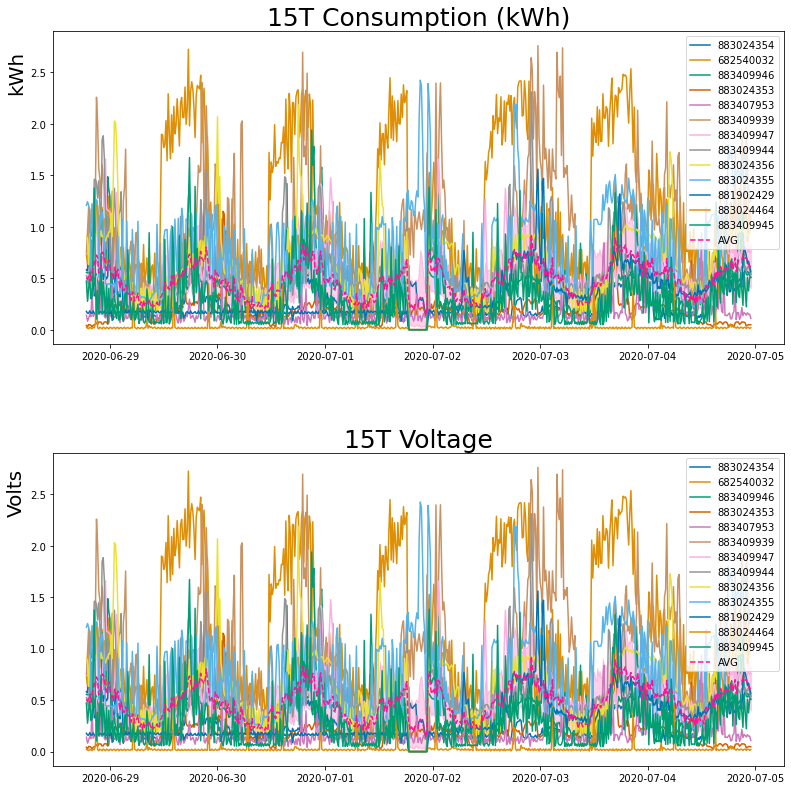

In [34]:
fig, (ax0,ax1) = plt.subplots(2, 1, num=fig_num, figsize=[14, 12])
subplots_adjust_args = {'left':0.075, 'right':0.80, 
                        'bottom':0.10, 'top':0.95, 
                        'wspace':0.2, 'hspace':0.35}
plt.subplots_adjust(**subplots_adjust_args)

fig,ax0 = AMINonVee.plot_usage(
    fig, ax0, data=df_usg_i_kwh, 
    x='time_idx', y='value', hue='serialnumber', 
    title_args=dict(label=f'15T Consumption (kWh)', fontsize=25), 
    #df_mean=dfs_kwh_dict['H'][df_agg_key], df_mean_col='mean_TRS mean_mtrs value', mean_args=None, 
    ylabel_args = dict(ylabel='kWh', fontsize=20, x=0.0, y=0.8, ha='left', va='bottom'), 
    xlabel_args = dict(xlabel='', fontsize=0, x=0.9, y=0.0, ha='right', va='top'), 
    draw_without_hue_also=True, seg_line_freq='D'
)

fig,ax1 = AMINonVee.plot_usage(
    fig, ax1, data=df_usg_i_vlt, 
    x='time_idx', y='value', hue='serialnumber', 
    title_args=dict(label=f'15T Voltage', fontsize=25), 
    #df_mean=dfs_kwh_dict['H'][df_agg_key], df_mean_col='mean_TRS mean_mtrs value', mean_args=None, 
    ylabel_args = dict(ylabel='Volts', fontsize=20, x=0.0, y=0.8, ha='left', va='bottom'), 
    xlabel_args = dict(xlabel='', fontsize=0, x=0.9, y=0.0, ha='right', va='top'), 
    draw_without_hue_also=True, seg_line_freq='D'
)

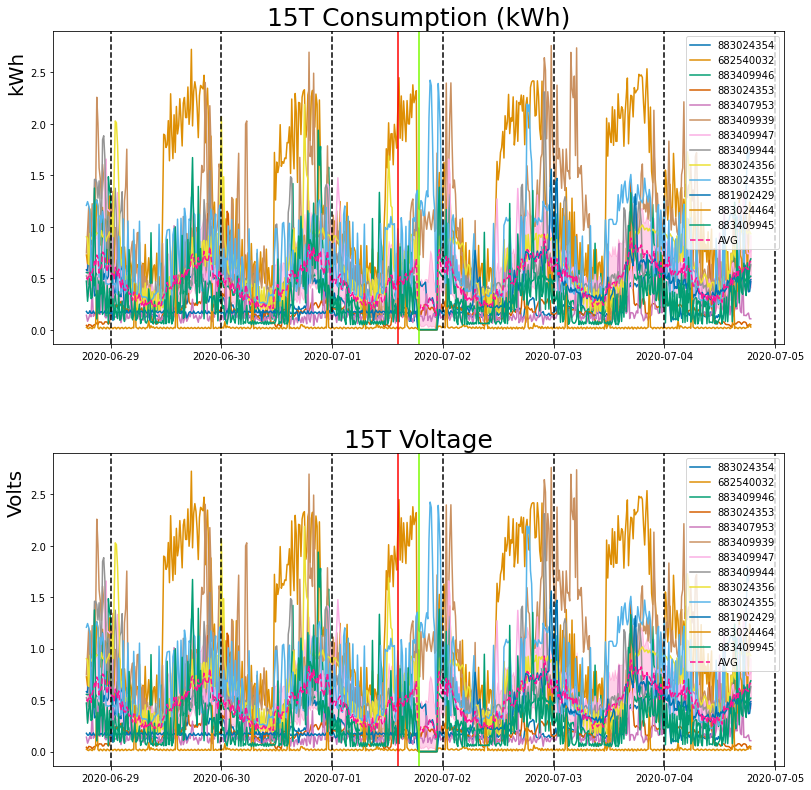

In [35]:
fig, (ax0,ax1) = plt.subplots(2, 1, num=fig_num, figsize=[14, 12])
subplots_adjust_args = {'left':0.075, 'right':0.80, 
                        'bottom':0.10, 'top':0.95, 
                        'wspace':0.2, 'hspace':0.35}
plt.subplots_adjust(**subplots_adjust_args)

fig,ax0 = AMINonVee.plot_usage_around_outage(
    fig, ax0, data=df_usg_i_kwh, 
    x='time_idx', y='value', hue='serialnumber', 
    out_t_beg=out_t_beg, out_t_end=out_t_end, expand_time=expand_time, data_label='', 
    title_args=dict(label=f'15T Consumption (kWh)', fontsize=25), 
    #df_mean=dfs_kwh_dict['H'][df_agg_key], df_mean_col='mean_TRS mean_mtrs value', mean_args=None, 
    ylabel_args = dict(ylabel='kWh', fontsize=20, x=0.0, y=0.8, ha='left', va='bottom'), 
    xlabel_args = dict(xlabel='', fontsize=0, x=0.9, y=0.0, ha='right', va='top'), 
    draw_outage_limits=True, draw_without_hue_also=True, seg_line_freq='D'
)

fig,ax1 = AMINonVee.plot_usage_around_outage(
    fig, ax1, data=df_usg_i_vlt, 
    x='time_idx', y='value', hue='serialnumber', 
    out_t_beg=out_t_beg, out_t_end=out_t_end, expand_time=expand_time, data_label=None, 
    title_args=dict(label=f'15T Voltage', fontsize=25), 
    #df_mean=dfs_kwh_dict['H'][df_agg_key], df_mean_col='mean_TRS mean_mtrs value', mean_args=None, 
    ylabel_args = dict(ylabel='Volts', fontsize=20, x=0.0, y=0.8, ha='left', va='bottom'), 
    xlabel_args = dict(xlabel='', fontsize=0, x=0.9, y=0.0, ha='right', va='top'), 
    draw_outage_limits=True, draw_without_hue_also=True, seg_line_freq='D'
)

In [36]:
df_outage_a = df_outage_OG.copy()
df_outage_b = df_outage_OG.copy()

In [37]:
assert(0)
#!!!!! Might need to tweak as this was developed with old version of DOVSOutages.consolidate_df_outage
df_outage_b = DOVSOutages.consolidate_df_outage(df_outage_b)

In [38]:
df_outage_b

,OUTG_REC_NB,CI_NB,CMI_NB,OUTAGE_NB,DT_ON_TS,DT_OFF_TS,DT_OFF_TS_FULL,STEP_DRTN_NB,START_YEAR,OPERATING_UNIT_ID,...,SHORT_NM_CLR_DEV,EQUIP_TYP_NM,SHORT_NM_EQP_TYP,MJR_CAUSE_NM,MNR_CAUSE_NM,search_time_half_window,t_search_min,t_search_max,serial_number,PREMISE_NBS
idx,,,,,,,,,,,,,,,,,,,,,
10143524,10143524,24,2240.0,3527481,2017-09-16 19:45:00,2017-09-16 00:00:00,2017-09-16 18:07:00,98.0,2017,3,...,DIP FUSE,CONDUCTOR UG,UG COND,DISTRIBUTION LINE,EQUIPMENT FAILURE,3 days,2017-09-13 18:07:00,2017-09-19 19:45:00,774152886,"[100420620, 100547600, 100683783, 101020620, 1..."
11770899,11770899,13,3536.0,3142991,2020-07-01 18:50:00,2020-07-01 00:00:00,2020-07-01 14:18:00,272.0,2020,3,...,XFMR FUSE,NONE,NONE,DISTRIBUTION LINE,OVERLOAD,3 days,2020-06-28 14:18:00,2020-07-04 18:50:00,883409946,"[070508983, 071048983, 071108983, 072018983, 0..."
11946640,11946640,10,260.0,3641081,2020-10-12 15:24:00,2020-10-12 00:00:00,2020-10-12 14:58:00,26.0,2020,3,...,XFMR FUSE,NONE,NONE,DISTRIBUTION LINE,TREE OUT OF ROW,3 days,2020-10-09 14:58:00,2020-10-15 15:24:00,645791455,"[101137530, 107337530, 107726383, 109236383]"
11947217,11947217,23,2001.0,3643381,2020-10-12 20:45:00,2020-10-12 00:00:00,2020-10-12 19:18:00,87.0,2020,3,...,DIP FUSE,CONDUCTOR UG,UG COND,DISTRIBUTION LINE,EQUIPMENT FAILURE,3 days,2020-10-09 19:18:00,2020-10-15 20:45:00,774152886,"[100420620, 100547600, 100683783, 101020620, 1..."


In [39]:
# FUCK


In [40]:
df_construct_type=DFConstructType.kRunSqlQuery
contstruct_df_args_end_events=None
end_events_sql_function_kwargs = dict(
    cols_of_interest=cols_of_interest_end_dev_event, 
    df_outage=df_outage_a, 
    join_mp_args=dict(join_with_CTE=True, 
                      build_mp_kwargs=dict(cols_of_interest=cols_of_interest_met_prem))
)
addtnl_end_events_sql_function_kwargs = dict(
    build_sql_function_kwargs=dict(opco='oh')
)
end_events_sql_function_kwargs = {**end_events_sql_function_kwargs, 
                                  **addtnl_end_events_sql_function_kwargs}
start=time.time()
end_events_a = AMIEndEvents(
    df_construct_type=df_construct_type, 
    contstruct_df_args = contstruct_df_args_end_events, 
    build_sql_function=AMIEndEvents_SQL.build_sql_end_events_for_outages, 
    build_sql_function_kwargs=end_events_sql_function_kwargs, 
    init_df_in_constructor=True
)
end_events_build_time_a = time.time()-start

In [41]:
df_construct_type=DFConstructType.kRunSqlQuery
contstruct_df_args_end_events=None
end_events_sql_function_kwargs = dict(
    cols_of_interest=cols_of_interest_end_dev_event, 
    df_outage=df_outage_b, 
    build_sql_function_kwargs=dict(), 
    join_mp_args=dict(join_with_CTE=True, 
                      build_mp_kwargs=dict(cols_of_interest=cols_of_interest_met_prem)), 
    df_args = dict(mapping_to_ami=DfToSqlMap(df_col='PREMISE_NBS', kwarg='premise_nbs', sql_col='aep_premise_nb'), 
                   is_df_consolidated=True)
)
addtnl_end_events_sql_function_kwargs = dict(
    build_sql_function_kwargs=dict(opco='oh')
)
end_events_sql_function_kwargs = {**end_events_sql_function_kwargs, 
                                  **addtnl_end_events_sql_function_kwargs}
start=time.time()
end_events_b = AMIEndEvents(
    df_construct_type=df_construct_type, 
    contstruct_df_args = contstruct_df_args_end_events, 
    build_sql_function=AMIEndEvents_SQL.build_sql_end_events_for_outages, 
    build_sql_function_kwargs=end_events_sql_function_kwargs, 
    init_df_in_constructor=True
)
end_events_build_time_b = time.time()-start

In [42]:
end_events_a.df

,issuertracking_id,serialnumber,enddeviceeventtypeid,valuesinterval,aep_premise_nb,reason,event_type,aep_opco,aep_event_dt,mfr_devc_ser_nbr,...,station_nb,station_nm,xfmr_nb,annual_kwh,annual_max_dmnd,mtr_stat_cd,mtr_stat_cd_desc,devc_stat_cd,devc_stat_cd_desc,outg_rec_nb_gpd_for_sql
0,1-1339657216,881902429,3.26.136.47,2020-07-01T14:18:18-04:00,073608983,Last Gasp - NIC power lost for device: 00:13:5...,3,oh,2020-07-01,881902429,...,2017,UPSANDUSK,4,3456.000,0.000,C,CONNECTED,A,ACTIVE,11770899
1,1-1339970458,881902429,3.26.38.150,2020-07-01T14:18:19-04:00,073608983,Under Voltage (CA000400) occurred for meter 00...,3,oh,2020-07-01,881902429,...,2017,UPSANDUSK,4,3456.000,0.000,C,CONNECTED,A,ACTIVE,11770899
2,1-1339970459,881902429,3.26.0.47,2020-07-01T14:18:20-04:00,073608983,Primary Power Down occurred for meter 00:13:50...,3,oh,2020-07-01,881902429,...,2017,UPSANDUSK,4,3456.000,0.000,C,CONNECTED,A,ACTIVE,11770899
3,1-142194151,640336153,3.26.0.47,2017-09-16T18:03:00-04:00,106747600,Primary Power Down occurred for meter 00:13:50...,3,oh,2017-09-16,640336153,...,0009,KARL ROAD,,3598.000,0.000,C,CONNECTED,A,ACTIVE,10143524
4,1-142224017,640336151,3.26.0.216,2017-09-16T19:45:11-04:00,103647600,Primary Power Up occurred for meter 00:13:50:0...,3,oh,2017-09-16,640336151,...,0009,KARL ROAD,,4095.000,0.000,C,CONNECTED,A,ACTIVE,10143524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,7-1483648073,761000248,3.26.0.216,2020-10-12T20:41:53.000-04:00,104430620,Primary Power Up occurred for meter 00:13:50:0...,3,oh,2020-10-12,761000248,...,0009,KARL ROAD,,27625.000,0.000,C,CONNECTED,A,ACTIVE,11947217
152,7-1483704870,640350247,3.26.0.47,2020-10-12T19:18:50.000-04:00,108393783,Primary Power Down occurred for meter 00:13:50...,3,oh,2020-10-12,640350247,...,0009,KARL ROAD,,9654.000,0.000,C,CONNECTED,A,ACTIVE,11947217
153,7-1483705385,640350245,3.26.0.216,2020-10-12T20:42:07.000-04:00,105293783,Primary Power Up occurred for meter 00:13:50:0...,3,oh,2020-10-12,640350245,...,0009,KARL ROAD,,8114.000,0.000,C,CONNECTED,A,ACTIVE,11947217
154,8-1339971668,883409947,3.26.0.47,2020-07-01T14:18:18-04:00,071108983,Primary Power Down occurred for meter 00:13:50...,3,oh,2020-07-01,883409947,...,2017,UPSANDUSK,4,15523.000,0.000,C,CONNECTED,A,ACTIVE,11770899


In [43]:
end_events_b.df

,issuertracking_id,serialnumber,enddeviceeventtypeid,valuesinterval,aep_premise_nb,reason,event_type,aep_opco,aep_event_dt,mfr_devc_ser_nbr,...,station_nb,station_nm,xfmr_nb,annual_kwh,annual_max_dmnd,mtr_stat_cd,mtr_stat_cd_desc,devc_stat_cd,devc_stat_cd_desc,outg_rec_nb_gpd_for_sql
0,1-1339657216,881902429,3.26.136.47,2020-07-01T14:18:18-04:00,073608983,Last Gasp - NIC power lost for device: 00:13:5...,3,oh,2020-07-01,881902429,...,2017,UPSANDUSK,4,3456.000,0.000,C,CONNECTED,A,ACTIVE,11770899
1,1-1339970458,881902429,3.26.38.150,2020-07-01T14:18:19-04:00,073608983,Under Voltage (CA000400) occurred for meter 00...,3,oh,2020-07-01,881902429,...,2017,UPSANDUSK,4,3456.000,0.000,C,CONNECTED,A,ACTIVE,11770899
2,1-1339970459,881902429,3.26.0.47,2020-07-01T14:18:20-04:00,073608983,Primary Power Down occurred for meter 00:13:50...,3,oh,2020-07-01,881902429,...,2017,UPSANDUSK,4,3456.000,0.000,C,CONNECTED,A,ACTIVE,11770899
3,1-142194151,640336153,3.26.0.47,2017-09-16T18:03:00-04:00,106747600,Primary Power Down occurred for meter 00:13:50...,3,oh,2017-09-16,640336153,...,0009,KARL ROAD,,3598.000,0.000,C,CONNECTED,A,ACTIVE,10143524
4,1-142224017,640336151,3.26.0.216,2017-09-16T19:45:11-04:00,103647600,Primary Power Up occurred for meter 00:13:50:0...,3,oh,2017-09-16,640336151,...,0009,KARL ROAD,,4095.000,0.000,C,CONNECTED,A,ACTIVE,10143524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,7-1483648073,761000248,3.26.0.216,2020-10-12T20:41:53.000-04:00,104430620,Primary Power Up occurred for meter 00:13:50:0...,3,oh,2020-10-12,761000248,...,0009,KARL ROAD,,27625.000,0.000,C,CONNECTED,A,ACTIVE,11947217
152,7-1483704870,640350247,3.26.0.47,2020-10-12T19:18:50.000-04:00,108393783,Primary Power Down occurred for meter 00:13:50...,3,oh,2020-10-12,640350247,...,0009,KARL ROAD,,9654.000,0.000,C,CONNECTED,A,ACTIVE,11947217
153,7-1483705385,640350245,3.26.0.216,2020-10-12T20:42:07.000-04:00,105293783,Primary Power Up occurred for meter 00:13:50:0...,3,oh,2020-10-12,640350245,...,0009,KARL ROAD,,8114.000,0.000,C,CONNECTED,A,ACTIVE,11947217
154,8-1339971668,883409947,3.26.0.47,2020-07-01T14:18:18-04:00,071108983,Primary Power Down occurred for meter 00:13:50...,3,oh,2020-07-01,883409947,...,2017,UPSANDUSK,4,15523.000,0.000,C,CONNECTED,A,ACTIVE,11770899


In [44]:
end_events_a.df_equals(end_events_b)

True